## XGBoost applied on FAANG stocks

In [2]:
import warnings
warnings.simplefilter('ignore')

import xgboost

from xgboost import XGBClassifier

#classification report and confusion matris
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#yahoo finance data
from pandas_datareader import data

import matplotlib.pyplot as plt
import seaborn as sn

import pandas as pd
import numpy as np

In [3]:
stock_list = ['FB' , 'AAPL' , 'AMZN' , 'NFLX' , 'GOOG']

start_date = '2004-1-1'
end_date = '2020-2-12'


In [4]:
stock_data_dictionary = {}

for stock_name in stock_list:

    df = data.get_data_yahoo(stock_name, start_date, end_date)
    
    #daily percent change
    df['daily_pct_change'] = df['Adj Close'].pct_change()
    
    #predictors
    predictor_list = []
    for r in range(10, 60, 5):
        df['pct_change_'+str(r)] = df.daily_pct_change.rolling(r).sum()
        df['std_'+str(r)] = df.daily_pct_change.rolling(r).std()
        predictor_list.append('pct_change_'+str(r))
        predictor_list.append('std_'+str(r))
        
    #targe variable
    df['return_next_day'] = df.daily_pct_change.shift(-1)
    df['actual_signal'] = np.where(df.return_next_day > 0, 1, -1)
    
    df = df.dropna()
    
    stock_data_dictionary.update({stock_name: df})

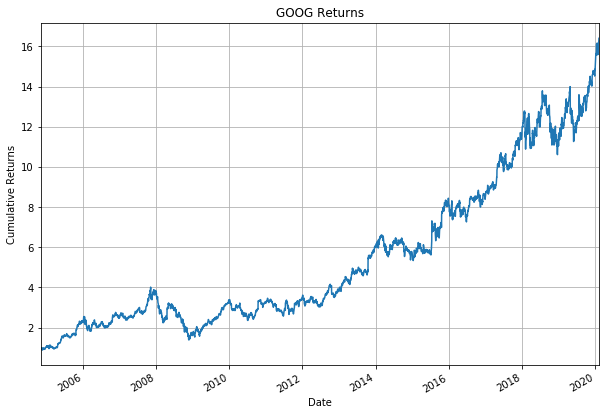

In [5]:
plt.figure(figsize=(10, 7))
# Access the dataframe of GOOG from the dictionary
# and then compute and plot the returns

(stock_data_dictionary['GOOG'].daily_pct_change+1).cumprod().plot()
    
# Set the title and axis lables and plot grid
plt.title('GOOG Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

In [ ]:
#Training data and test data

In [6]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()
    
for stock_name in stock_list:
        
    # Get predictor variables
    X = stock_data_dictionary[stock_name][predictor_list]
    
    # Get the target variable
    y = stock_data_dictionary[stock_name].actual_signal
    
    # Divide the dataset into train and test
    train_length = int(len(X)*0.80)
    X_train = X_train.append(X[:train_length])
    X_test = X_test.append(X[train_length:])
    y_train = y_train.append(y[:train_length])
    y_test = y_test.append(y[train_length:])

In [7]:
#Initialising the XGBoost model

In [8]:
model = XGBClassifier(max_depth =3, n_estimators=500, learning_rate=0.05)

model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [9]:
#Cross validation

kfold = KFold (n_splits=5, random_state=7)

results = cross_val_score(model,X_train, y_train, cv=kfold)
mresults = results.mean()*100
stdresults = results.std()*100

print(f"Accuracy: {mresults} ({stdresults})")

Accuracy: 50.941135001762426 (0.6915896210605964)


In [11]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

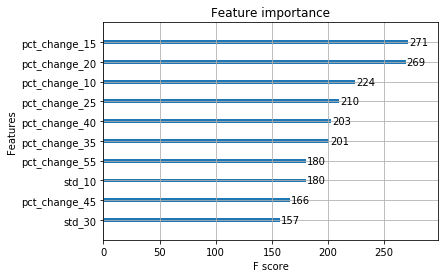

In [12]:
xgboost.plot_importance(model,max_num_features=10)
plt.show()

In [ ]:
#predict and classification report

In [13]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.48      0.35      0.40      1629
           1       0.55      0.68      0.61      1918

    accuracy                           0.53      3547
   macro avg       0.51      0.51      0.51      3547
weighted avg       0.52      0.53      0.51      3547



In [ ]:
#confusion matrix

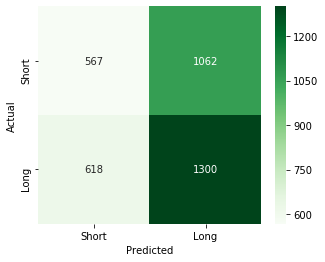

In [15]:
array = confusion_matrix(y_test, y_pred)

df = pd.DataFrame(array, index=['Short', 'Long'], columns=['Short', 'Long'])
    
plt.figure(figsize=(5, 4))
sn.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
#Individual stock performance

FB


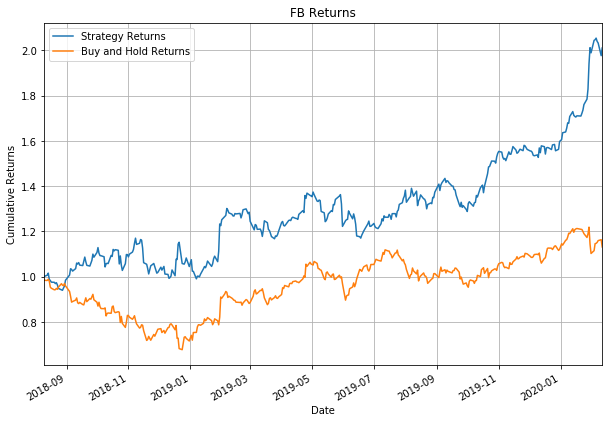

AAPL


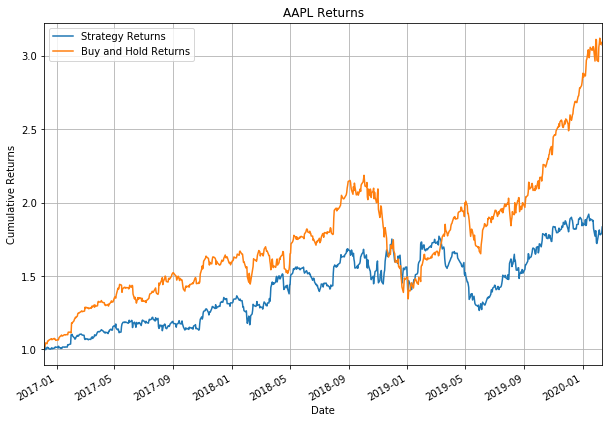

AMZN


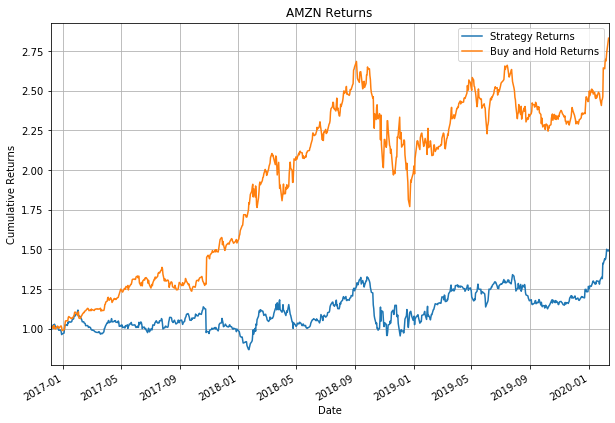

NFLX


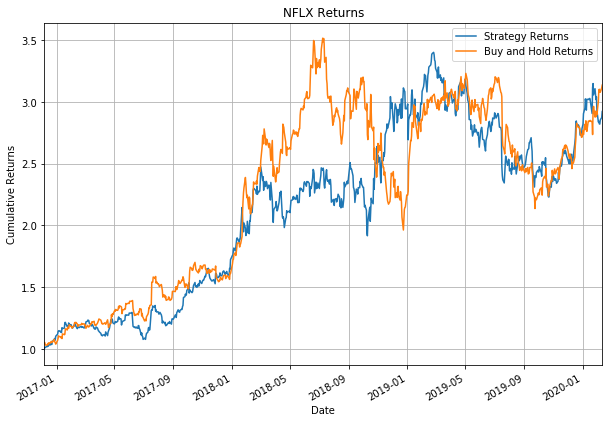

GOOG


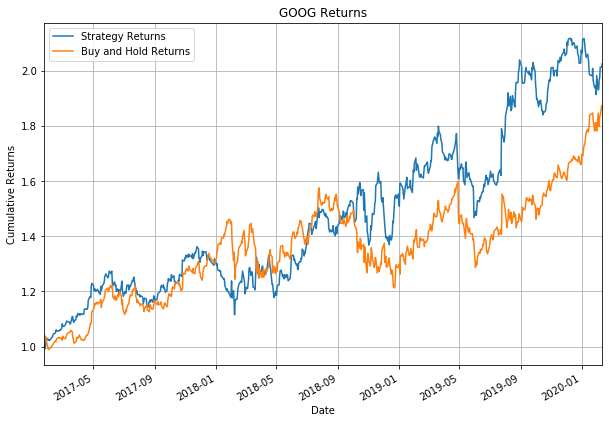

In [18]:
# Create an empty dataframe to store the strategy returns of individual stocks\n",
portfolio = pd.DataFrame(columns=stock_list)
    
# For each stock in the stock list, plot the strategy returns and buy and hold returns\n",
for stock_name in stock_list:

# Get the data
    df = stock_data_dictionary[stock_name]
    # Store the predictor variables in X
    X = df[predictor_list]
    
    #Define the train and test dataset
    train_length = int(len(X)*0.80)
    
    # Predict the signal and store in predicted signal column
    df['predicted_signal'] = model.predict(X)
    
    # Calculate the strategy returns
    df['strategy_returns'] = df.return_next_day * df.predicted_signal
    
    # Add the strategy returns to the portfolio dataframe
    portfolio[stock_name] = df.strategy_returns[train_length:]
    
    #Plot the stock strategy and buy and hold returns
    print(stock_name)
    
    #Set the figure size
    plt.figure(figsize=(10, 7))
    
    # Calculate the cumulative strategy returns and plot
    (df.strategy_returns[train_length:]+1).cumprod().plot()
    
    # Calculate the cumulative buy and hold strategy returns
    (stock_data_dictionary[stock_name][train_length:].daily_pct_change+1).cumprod().plot()    
    
    # Set the title, label and grid
    plt.title(stock_name + ' Returns')
    plt.ylabel('Cumulative Returns')
    plt.legend(labels=['Strategy Returns', 'Buy and Hold Returns'])
    plt.grid()
    plt.show()

In [ ]:
#Performance of portfolio

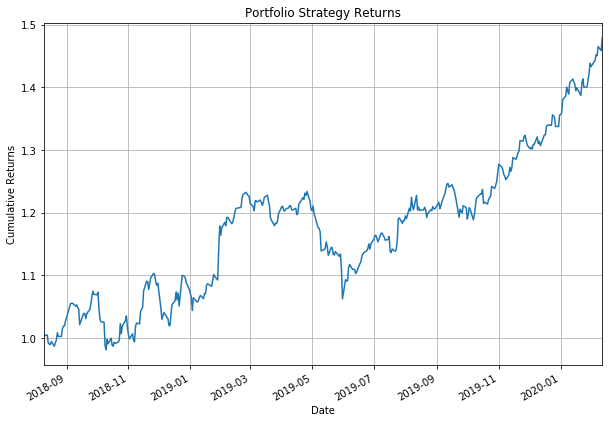

In [19]:
# Drop missing values 
portfolio.dropna(inplace=True) 

# Set the figure size 
plt.figure(figsize=(10, 7)) 
    
# Calculate the cumulative portfolio returns by assuming equal allocation to the stocks 
(portfolio.mean(axis=1)+1).cumprod().plot() 
    
# Set the title and label of the chart 
plt.title('Portfolio Strategy Returns') 
plt.ylabel('Cumulative Returns') 
plt.grid() 
plt.show()

Start date,2018-08-10
End date,2020-02-11
Total months,18
,Backtest
Annual return,29.8%
Cumulative returns,47.8%
Annual volatility,15.9%
Sharpe ratio,1.72
Calmar ratio,2.14
Stability,0.80
Max drawdown,-13.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.90,2019-04-26,2019-05-31,2019-09-10,98
1,8.68,2018-09-27,2018-10-10,2018-11-16,37
2,7.58,2018-11-26,2018-12-12,2019-01-29,47
3,4.66,2019-09-12,2019-10-07,2019-10-30,35
4,4.34,2019-02-25,2019-03-25,2019-04-26,45


Stress Events,mean,min,max
New Normal,0.11%,-4.24%,4.65%


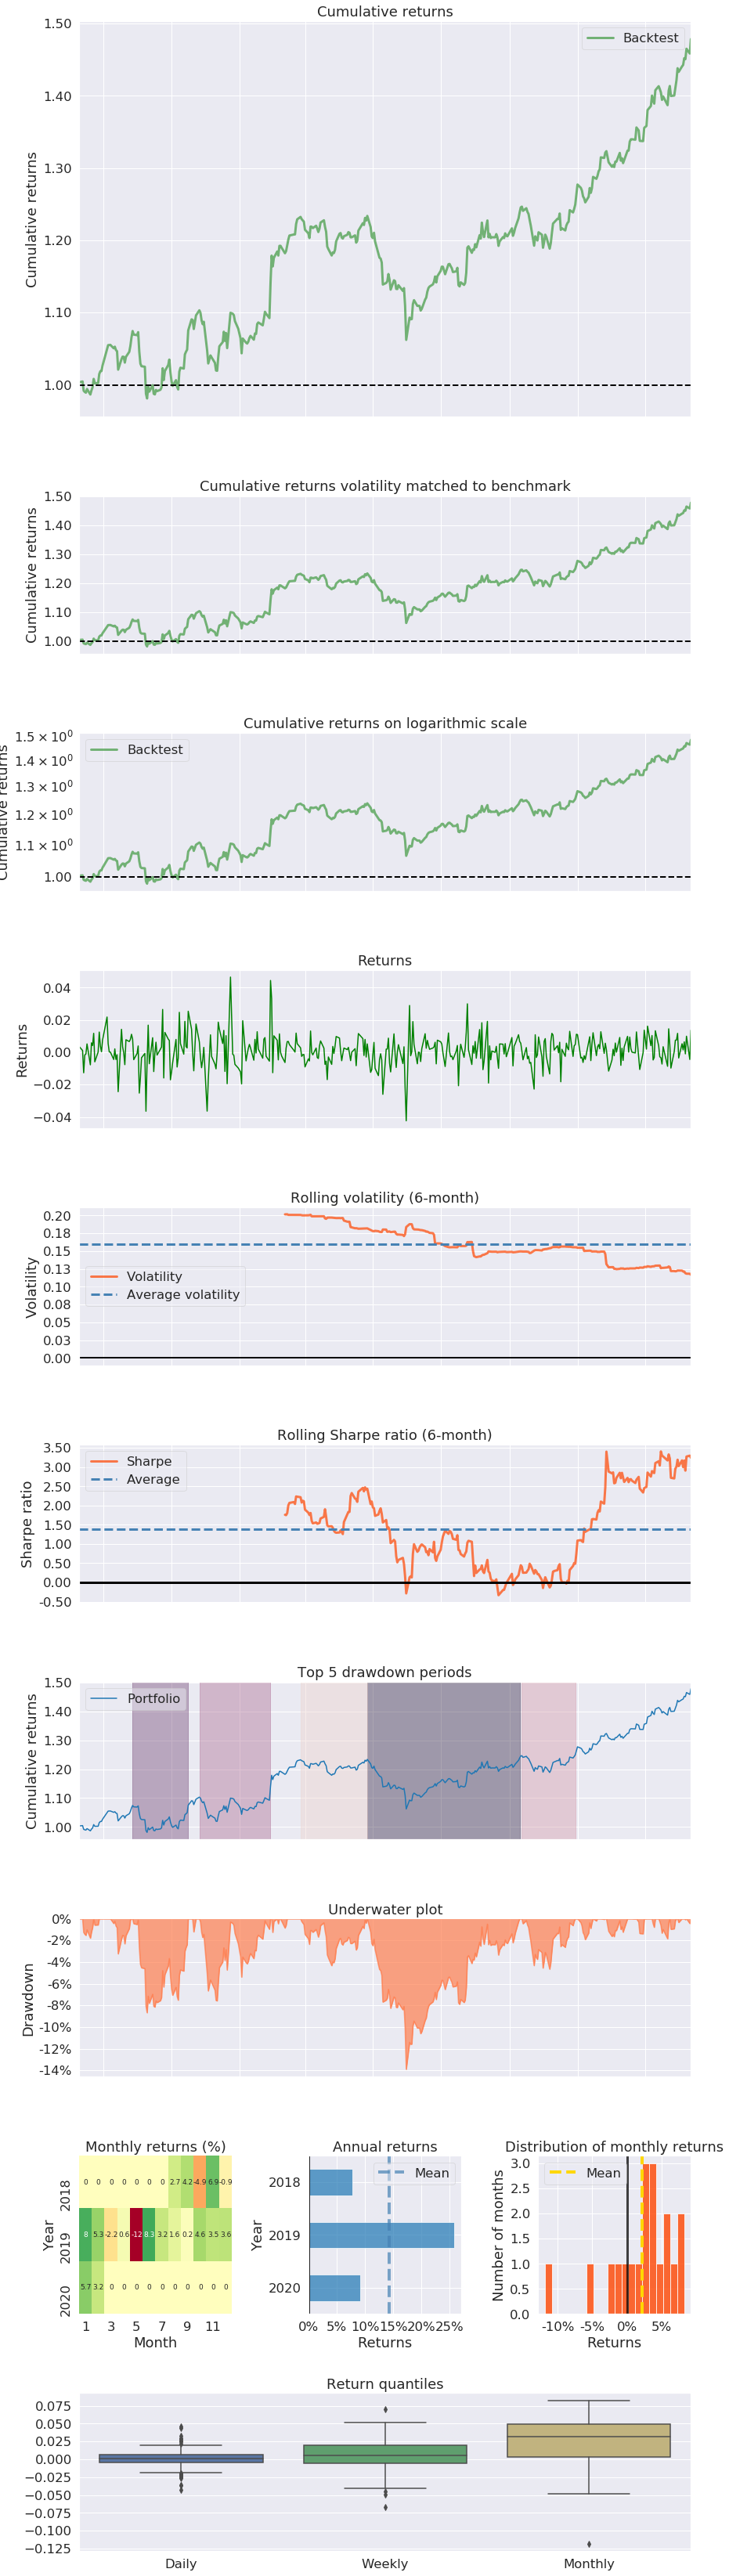

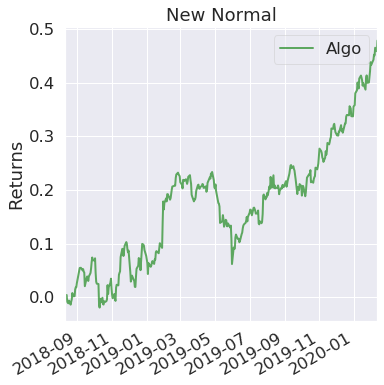

In [21]:
#detailed feedback on the test set

import pyfolio as pf
pf.create_full_tear_sheet(portfolio.mean(axis=1))